# kaggle项目：员工离职预测分析
EDA, Random forest, Clustering

### 导入数据，查看数据基本情况

In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv('HR.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
left                     14999 non-null int64
promotion_last_5years    14999 non-null int64
sales                    14999 non-null object
salary                   14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


可以看到数据非常干净，不需要处理缺失值。有两个object类型，其中的字符值无法进行机器学习计算，因此需要对字符值进行转换。

In [2]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


### 特征  
1. 员工满意程度：0-1，越接近于0说明员工越不满意；  
2. 公司对员工的评价：0-1，越接近于0说明公司对员工评价越低；  
3. 员工项目数  
4. 每月工作时间  
5. 工作年限   
6. 工作事故  
7. 过去5年是否升职
8. 部门  
9. 工资  

标签：left  是否离职

In [3]:
# 更改不明确的列的名字
df.rename(columns={'average_montly_hours':'average_monthly_hours', 'sales':'department','Work_accident':'work_accident'}, 
          inplace=True)
df.describe()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


## 探索性分析

### 1. 统计不同部门人数，不同等级工资人数。

In [4]:
# Department Types, Salary Classification Range
print ('Departments:')
print (df['department'].value_counts())
print ('\nSalary:')
print (df['salary'].value_counts())

Departments:
sales          4140
technical      2720
support        2229
IT             1227
product_mng     902
marketing       858
RandD           787
accounting      767
hr              739
management      630
Name: department, dtype: int64

Salary:
low       7316
medium    6446
high      1237
Name: salary, dtype: int64


[Text(0, 0, 'sales'),
 Text(0, 0, 'technical'),
 Text(0, 0, 'support'),
 Text(0, 0, 'IT'),
 Text(0, 0, 'product_mng'),
 Text(0, 0, 'marketing'),
 Text(0, 0, 'RandD'),
 Text(0, 0, 'accounting'),
 Text(0, 0, 'hr'),
 Text(0, 0, 'management')]

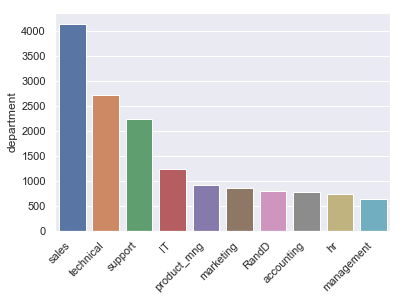

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

deptplot = sns.barplot(x = df['department'].value_counts().index, y= df['department'].value_counts())
deptplot.set_xticklabels(rotation=45, labels=df['department'].value_counts().index,horizontalalignment='right')# 设置横坐标的显示方式

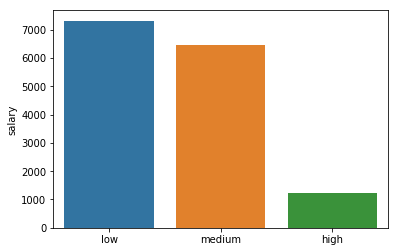

In [7]:
salaryplot = sns.barplot(x = df['salary'].value_counts().index, y= df['salary'].value_counts())

### 2. 查看不同指标之间的相关系数  

In [5]:
# correlation coefficient
df.corr()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years
satisfaction_level,1.000000,0.105021,-0.142970,-0.020048,-0.100866,0.058697,-0.388375,0.025605
last_evaluation,0.105021,1.000000,0.349333,0.339742,0.131591,-0.007104,0.006567,-0.008684
number_project,-0.142970,0.349333,1.000000,0.417211,0.196786,-0.004741,0.023787,-0.006064
average_monthly_hours,-0.020048,0.339742,0.417211,1.000000,0.127755,-0.010143,0.071287,-0.003544
time_spend_company,-0.100866,0.131591,0.196786,0.127755,1.000000,0.002120,0.144822,0.067433
work_accident,0.058697,-0.007104,-0.004741,-0.010143,0.002120,1.000000,-0.154622,0.039245
left,-0.388375,0.006567,0.023787,0.071287,0.144822,-0.154622,1.000000,-0.061788
promotion_last_5years,0.025605,-0.008684,-0.006064,-0.003544,0.067433,0.039245,-0.061788,1.000000


查看有没有相关性较大的指标，如果相关性较大，在特征选择时选择其中一个特征即可。  
查看标签和各个特征的相关系数，满意程度和离职的相关性最大，且是负相关关系，可以格外关注；其他属性与标签相关性略小。

### 3. 不同职位对离职的影响

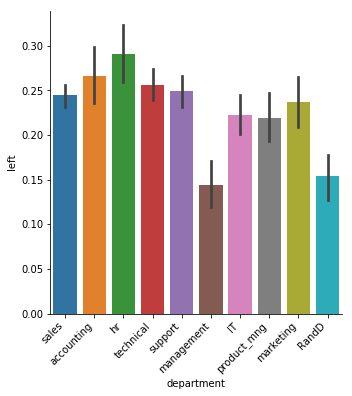

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# the relationship between left and department
dlplot = sns.catplot(x = 'department', y = 'left', kind = 'bar', data = df)
dlplot.set_xticklabels(rotation = 45, horizontalalignment = 'right')

In [71]:
g1 = df['left'].groupby(df['department']).sum()
g2 = df['department'].value_counts()
res = g1 / g2
res.sort_values(ascending = False)

hr             0.290934
accounting     0.265971
technical      0.256250
support        0.248991
sales          0.244928
marketing      0.236597
IT             0.222494
product_mng    0.219512
RandD          0.153748
management     0.144444
dtype: float64

可以发现HR职位离职率最高，会计类岗位其次，管理类岗位离职率最低。

### 4. 工资对离职的影响

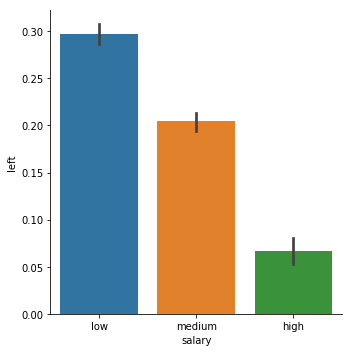

In [9]:
# salary and left
slplot = sns.catplot(x = 'salary',y = 'left',kind = 'bar',data = df)

#### 不同部门的工资分布

([<matplotlib.patches.Wedge at 0x2af3a082a58>,
 [Text(0.4772720865178074, 0.9910657674599294, 'medium'),
  Text(-1.0724206837565986, -0.24477311341532132, 'high'),
  Text(0.6858389085766268, -0.8600145298088989, 'low')])

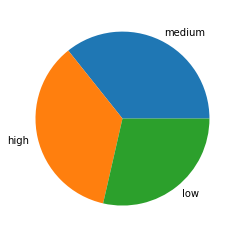

In [10]:
# the distribution of salary in different departments
# 管理部门
count_s = df[df['department'] == 'management']['salary'].value_counts()
plt.pie(count_s,labels = count_s.index)

([<matplotlib.patches.Wedge at 0x2af3a0bfa20>,
 [Text(0.09429156943616415, 1.0959512306363204, 'medium'),
  Text(-0.31392514344841843, -1.0542537665623444, 'low'),
  Text(1.0772829261641794, -0.2223994087113165, 'high')])

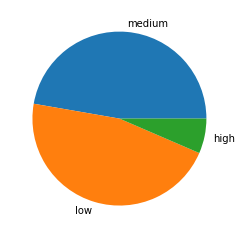

In [11]:
# 研发部门
count_s2 = df[df['department'] == 'RandD']['salary'].value_counts()
plt.pie(count_s2,labels = count_s2.index)

### 5. 满意程度对离职的影响

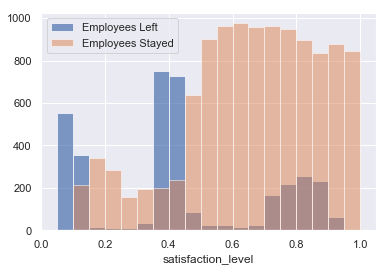

In [73]:
# satisfaction_level and left 
ls1 = df[df['left'] == 1]['satisfaction_level']
ls2 = df[df['left'] == 0]['satisfaction_level']

sns.set()
bins = np.linspace(0.0001, 1.0001, 21)

plt.hist(ls1, bins = bins, alpha = 0.7, label = 'Employees Left')
plt.hist(ls2, bins = bins, alpha = 0.5, label = 'Employees Stayed')
plt.xlabel('satisfaction_level')
plt.xlim((0,1.05))
plt.legend(loc='best')

对于离职员工，可以发现满意程度较低时离职人数很多，满意程度在0.4左右离职率较高，满意程度为0.8较高水平时，仍有员工离职，可做下一步探索。

### 6. 公司对员工评价对离职的影响

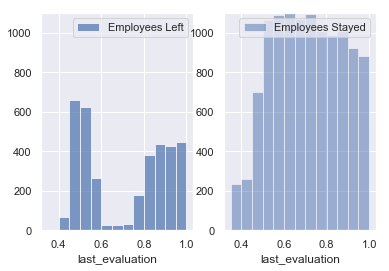

In [13]:
# last_evaluation and left
le1 = df[df['left'] == 1]['last_evaluation']
le2 = df[df['left'] == 0]['last_evaluation']

sns.set()
bins = np.linspace(0.3501, 1.0001, 14)
plt.subplot(1,2,1)
plt.hist(le1, bins = bins, alpha = 0.7, label = 'Employees Left')
plt.xlabel('last_evaluation')
plt.ylim((0,1100))
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.hist(le2, bins = bins, alpha = 0.5, label = 'Employees Stayed')
plt.xlabel('last_evaluation')
plt.ylim((0,1100))
plt.legend(loc='best')

可以发现评分在高中低三个阶段都有部分离职情况。评分较高时可能存在员工因为工资而跳槽等情况。

### 7. 项目数对离职的影响

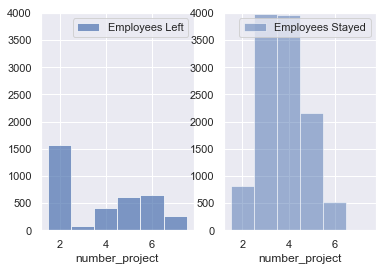

In [14]:
# number_project and left
le1 = df[df['left'] == 1]['number_project']
le2 = df[df['left'] == 0]['number_project']

sns.set()
bins = np.linspace(1.5, 7.5, 7)
plt.subplot(1,2,1)
plt.hist(le1, bins = bins, alpha = 0.7, label = 'Employees Left')
plt.xlabel('number_project')
plt.ylim((0,4000))
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.hist(le2, bins = bins, alpha = 0.5, label = 'Employees Stayed')
plt.xlabel('number_project')
plt.ylim((0,4000))
plt.legend(loc='best')

项目数少离职人数多，但不同数目范围都有一定离职人数。

### 8. 工作时长对离职的影响

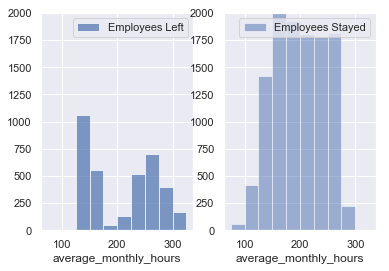

In [15]:
# average_monthly_hours and left
le1 = df[df['left'] == 1]['average_monthly_hours']
le2 = df[df['left'] == 0]['average_monthly_hours']

sns.set()
bins = np.linspace(75, 325, 11)
plt.subplot(1,2,1)
plt.hist(le1, bins = bins, alpha = 0.7, label = 'Employees Left')
plt.xlabel('average_monthly_hours')
plt.ylim((0,2000))
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.hist(le2, bins = bins, alpha = 0.5, label = 'Employees Stayed')
plt.xlabel('average_monthly_hours')
plt.ylim((0,2000))
plt.legend(loc='best')

低工作时长和高工作时长离职人数较多。

### 9. 工作年限对离职的影响

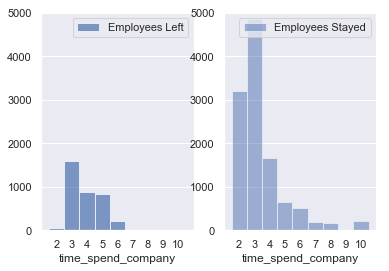

In [16]:
# time_spend_company and left
le1 = df[df['left'] == 1]['time_spend_company']
le2 = df[df['left'] == 0]['time_spend_company']

sns.set()
bins = np.linspace(1.5, 10.5, 10)
plt.subplot(1,2,1)
plt.hist(le1, bins = bins, alpha = 0.7, label = 'Employees Left')
plt.xlabel('time_spend_company')
plt.ylim((0,5000))
plt.xlim((1,11))
plt.grid(axis = 'x')
plt.xticks(np.arange(2,11))
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.hist(le2, bins = bins, alpha = 0.5, label = 'Employees Stayed')
plt.xlabel('time_spend_company')
plt.ylim((0,5000))
plt.xlim((1,11))
plt.grid(axis = 'x')
plt.xticks(np.arange(2,11))
plt.legend(loc='best')

离职者集中在工作年限少的人群中，工作年限较长的人一般很少选择离职。

### 10. 工作事故对离职的影响

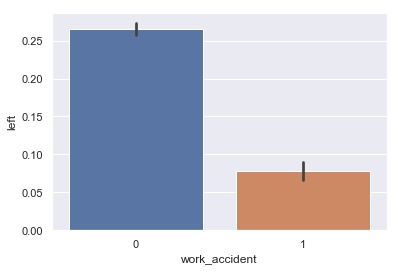

In [17]:
# work_accident and left
sns.barplot(x = 'work_accident',y = 'left',data = df)

没有事故的人离职率更高，发生事故的人离职率低，不太符合实际情况，在后续分析中可以不考虑这一特征。

### 11. 是否有升职对离职的影响

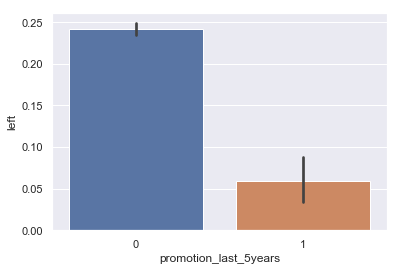

In [18]:
# promotion_last_5years and left
sns.barplot(x = 'promotion_last_5years',y = 'left',data = df)

## 特征工程

### 1. 将分类数据哑变量化
工资和部门是通过字符串的形式存储的，需要哑变量化。

In [79]:
# split features and labels
x = df.drop('left', axis=1)
y = df['left']
x.drop(['department','salary'], axis=1, inplace=True)

# transform the object type: One-hot encoding
salary_dummy = pd.get_dummies(df['salary'],prefix = 'salary',prefix_sep = '_')
department_dummy = pd.get_dummies(df['department'],prefix = 'depart',prefix_sep = '_')
x = pd.concat([x, salary_dummy], axis=1)
x = pd.concat([x, department_dummy], axis=1)
x.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,promotion_last_5years,salary_high,salary_low,salary_medium,depart_IT,depart_RandD,depart_accounting,depart_hr,depart_management,depart_marketing,depart_product_mng,depart_sales,depart_support,depart_technical
0,0.38,0.53,2,157,3,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0


### 2. 划分训练集与测试集

In [20]:
# split train set and test set
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3)

### 3. 数据预处理
标准化消除数据量纲差异的影响。

In [21]:
# data preprocessing
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaler = scaler.fit_transform(x_train)
x_test_scaler = scaler.transform(x_test)

C:\Users\fantasy\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\fantasy\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\fantasy\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  


## 建模分析

### 1. 随机森林建模

In [22]:
# Random Forest modeling
# 交叉验证与网格搜索调参
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits = 20, test_size = 0.3)
rf_model = RandomForestClassifier()
rf_param = {'n_estimators': range(1,11)}
rf_grid = GridSearchCV(rf_model, rf_param, cv = cv)
rf_grid.fit(x_train, y_train)

print('Parameter with best score:')
print(rf_grid.best_params_)
print('Cross validation score:', rf_grid.best_score_)

Parameter with best score:
{'n_estimators': 10}
Cross validation score: 0.983904761904762


In [23]:
best_rf = rf_grid.best_estimator_
print('Test score:', best_rf.score(x_test, y_test))

Test score: 0.9886666666666667


验证集效果：98.4%，测试集效果：98.9%

#### 查看特征重要性

In [24]:
# feature importances
features = x.columns
feature_importances = best_rf.feature_importances_
features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

features_df

,Features,Importance Score
0,satisfaction_level,0.285512
4,time_spend_company,0.214041
3,average_monthly_hours,0.168083
2,number_project,0.163001
1,last_evaluation,0.118989
8,salary_low,0.008232
7,salary_high,0.007203
5,work_accident,0.007155
17,depart_sales,0.004005
19,depart_technical,0.003903


可以发现最重要的特征是满意程度，其次是工作年限，工作时长，项目数，公司评价等。这个最重要的五个指标。

In [25]:
# the importances of the first five features
features_df['Importance Score'][:5].sum()

0.9496255137547319

### 2. 聚类分析

Text(0.5, 0, 'Satisfaction level')

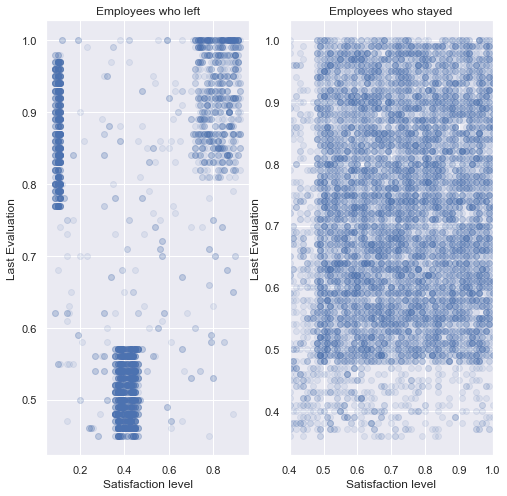

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

data = pd.read_csv('HR.csv')
data.rename(columns={'average_montly_hours':'average_monthly_hours', 'sales':'department','Work_accident':'work_accident'}, 
          inplace=True)
# explore the correlation between satisfaciton_level and last_evaluation
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(data.satisfaction_level[data.left == 1],data.last_evaluation[data.left == 1],'o', alpha = 0.1)
plt.ylabel('Last Evaluation')
plt.title('Employees who left')
plt.xlabel('Satisfaction level')

plt.subplot(1,2,2)
plt.title('Employees who stayed')
plt.plot(data.satisfaction_level[data.left == 0],data.last_evaluation[data.left == 0],'o', alpha = 0.1)
plt.xlim([0.4,1])
plt.ylabel('Last Evaluation')
plt.xlabel('Satisfaction level')
# suitable for clustering!

In [27]:
from sklearn.cluster import KMeans
kmeans_df =  data[data.left == 1].drop([ u'number_project',
       u'average_monthly_hours', u'time_spend_company', u'work_accident',
       u'left', u'promotion_last_5years', u'department', u'salary'],axis = 1)
kmeans = KMeans(n_clusters = 3, random_state = 0).fit(kmeans_df)
kmeans.cluster_centers_

array([[0.80851586, 0.91170931],
       [0.11115466, 0.86930085],
       [0.41014545, 0.51698182]])

C:\Users\fantasy\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


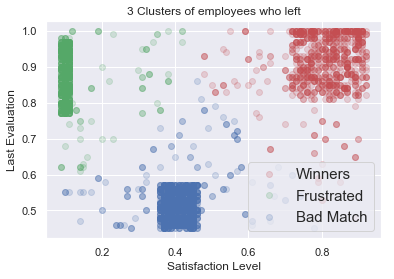

In [28]:
left = data[data.left == 1]
left['label'] = kmeans.labels_
plt.figure()
plt.xlabel('Satisfaction Level')
plt.ylabel('Last Evaluation')
plt.title('3 Clusters of employees who left')
plt.plot(left.satisfaction_level[left.label==0],left.last_evaluation[left.label==0],'o', alpha = 0.2, color = 'r')
plt.plot(left.satisfaction_level[left.label==1],left.last_evaluation[left.label==1],'o', alpha = 0.2, color = 'g')
plt.plot(left.satisfaction_level[left.label==2],left.last_evaluation[left.label==2],'o', alpha = 0.2, color = 'b')
plt.legend(['Winners','Frustrated','Bad Match'], loc = 'best', fontsize = 15,frameon=True)

使用公司对员工的评价和员工的满意度两个特征进行聚类分析，设置k=3，可以发现离职的员工聚成明显的三个簇。  
高满意度和高评价的离职员工可能是跳槽到更满意的其他公司；低满意度和高评价的员工可能是因为公司的某些情况达不到预期而跳槽；中等满意度和中等评价的员工则是可能想要寻找一个新的环境与新的突破。